# Загрузка

In [104]:
targets = ['Врем. сопротивление', 'Предел текучести']
ls_train_col = bath_.columns.difference(targets)

In [14]:
ls_bath_col = [
    't˚ C воды в закалочной ванне', 
    't˚ C трубы после ванны',
    'время выдержки в закалочной ванне, сек.'
]

In [99]:
ls_need_col = ['Врем. сопротивление', 'Предел текучести',
       'Тип предела текучести (1186)',
       '1 зона по ВТР закалка',
       '1 зона ВТР и уставка отпуск', 
       '2 зона ВТР и уставка отпуск',
       '2 зона по ВТР закалка', '3 зона ВТР и уставка отпуск',
       '3 зона по ВТР закалка', 
       '4 зона ВТР и уставка отпуск',
       '5 зона ВТР и уставка отпуск',
#        't˚ C воды в закалочной ванне', 
       't˚ C трубы после ванны',
       'время выдержки в закалочной ванне, сек.', 
       'диаметр', 
#        'марка стали',
       'толщина стенки', 
       'шаг балок закалочная печь, сек',
       'шаг балок отпускная печь, сек',
       'C', 'Mn', 'Si', 'P', 'S',
       'Cr', 'Ni', 'Cu', 'Al', 'V', 'Ti', 'Nb', 'Mo', 'N',
       'ICD',
       'C-coef', 'Параметр закалка', 'Параметр отпуск',
       'Параметр отпуск новый', 'Параметр отпуск новый 2',
       'Параметр отпуск новый V',
       'Величина зерна']

In [3]:
import pandas as pd
import numpy as np
import import_ipynb
from my_libs.calc_features import *
import random

importing Jupyter notebook from C:\Users\kseniya.yuldasheva\Desktop\gitPNTZtoyuk_1\gitPNTZ\PNTZ\my_libs\calc_features.ipynb


In [4]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, matthews_corrcoef, median_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, cross_validate, train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn import model_selection
import time
from sklearn.neural_network import MLPRegressor
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
from sklearn.preprocessing import LabelEncoder
from time import time
from datetime import datetime
import json
from my_libs.save_lib import save_RF_model
from scipy.stats.stats import pearsonr

importing Jupyter notebook from C:\Users\kseniya.yuldasheva\Desktop\gitPNTZtoyuk_1\gitPNTZ\PNTZ\my_libs\save_lib.ipynb


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
df = pd.read_csv('prepared_to_saw.csv', low_memory=False)

# Отделение таблицы с ванной и ее чистка

In [116]:
bath = df[~df['время выдержки в закалочной ванне, сек.'].isnull()].copy()

In [117]:
bath.drop(['Unnamed: 0',
           't˚ C трубы после спреера', 
           'Расход воды на закалочный спрейер, м3',
           'Скорость прохождения трубы через спрейер, м/с'],
          axis=1,
          inplace=True)
bath.shape

(1292, 61)

In [118]:
bath = bath[bath['время выдержки в закалочной ванне, сек.'] > 10]

In [119]:
bath.reset_index(inplace=True, drop=True)

In [120]:
bath['Дата термообработки'] = bath['Дата термообработки'].apply(lambda x: str(x).replace('T00:00:00.000000000', ''))

In [121]:
from datetime import datetime

In [122]:
tmp = []
for x in bath['Дата термообработки']:
    try:
        tmp.append(datetime.strptime(x, "%d-%m-%Y"))
    except ValueError:
        tmp.append(datetime.strptime(x, "%Y-%m-%d"))
bath['Дата термообработки'] = tmp

In [123]:
valid = bath[bath['Дата термообработки'].apply(lambda x:x.year)>2017].copy()
bath_ = bath[bath['Дата термообработки'].apply(lambda x:x.year)<2018].copy()

In [124]:
valid = valid[ls_need_col].dropna()
valid.reset_index(inplace=True, drop=True)

In [125]:
# Обрезана, оставлены только столбцы float
bath_ = bath[ls_need_col].dropna().copy()
bath_.reset_index(inplace=True, drop=True)

In [126]:
bath_.shape, valid.shape

((1160, 39), (137, 39))

# Визуализация

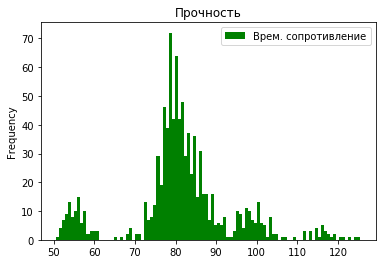

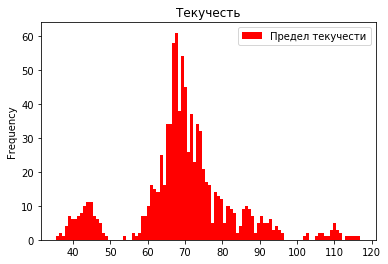

In [89]:
bath_.plot(y='Врем. сопротивление', kind='hist', color='green', title='Прочность', bins=100)
bath_.plot(y='Предел текучести', kind='hist', color='red', title='Текучесть', bins=100)
plt.show()

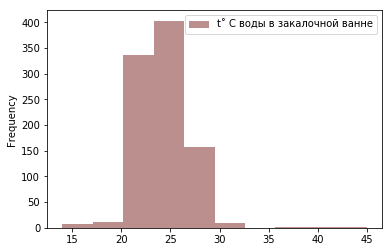

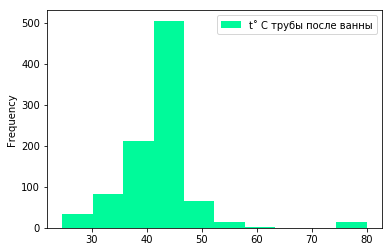

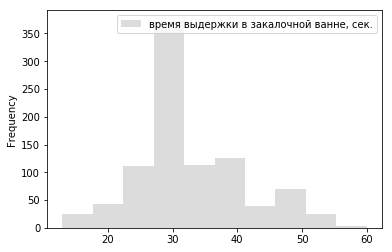

In [90]:
import matplotlib._color_data as mcd
import matplotlib.patches as mpatch

# Гля, рандомные цвета! *___*
overlap = {name for name in mcd.CSS4_COLORS}

plt.rcParams.update({'font.size': 10})
for col in ls_bath_col:
    weight = None
    bath_.plot(y=col, kind='hist', 
              color=random.choice(list(overlap)),
             bins=10)

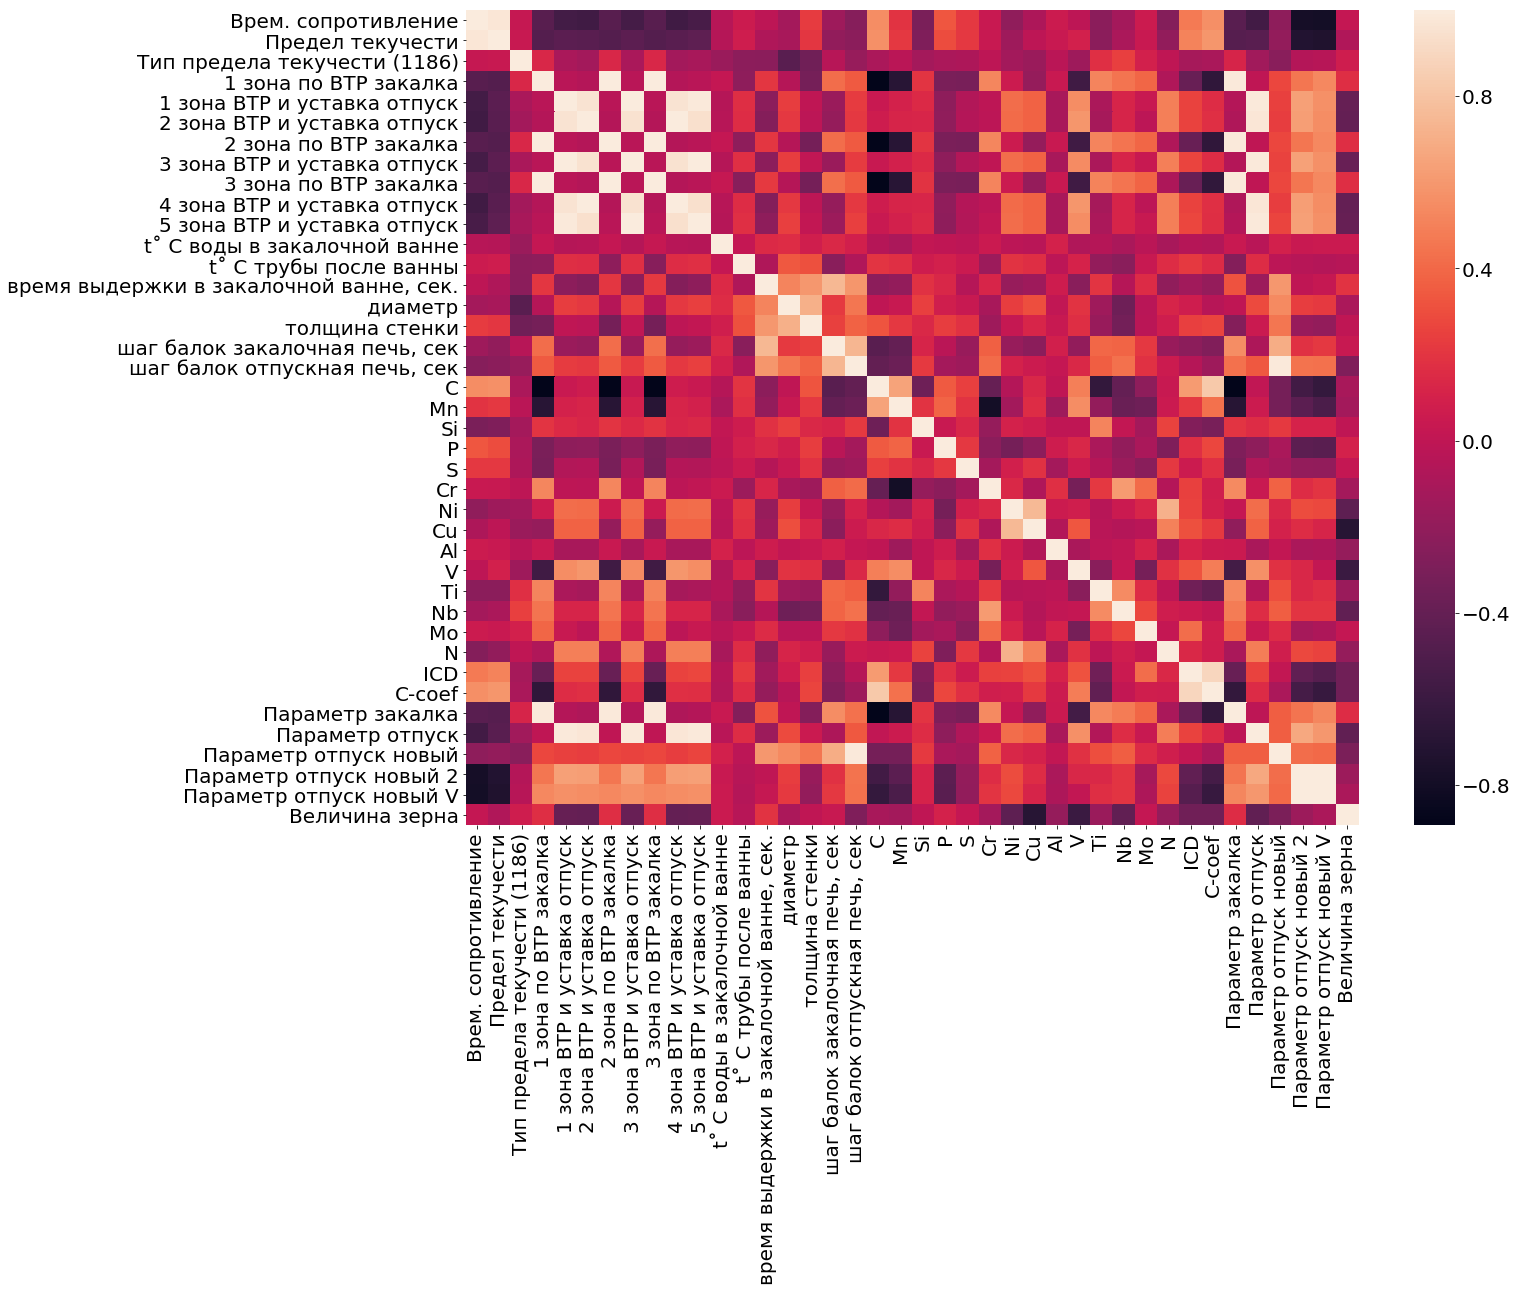

In [91]:
plt.rcParams.update({'font.size': 20})
plt.subplots(figsize=(20,15))

corr = bath_.corr()
corr_hm = sns.heatmap(corr)
fig = corr_hm.get_figure()
# fig.savefig('heatmap_bath.jpg', bbox_inches = 'tight')

<Figure size 1440x1440 with 0 Axes>

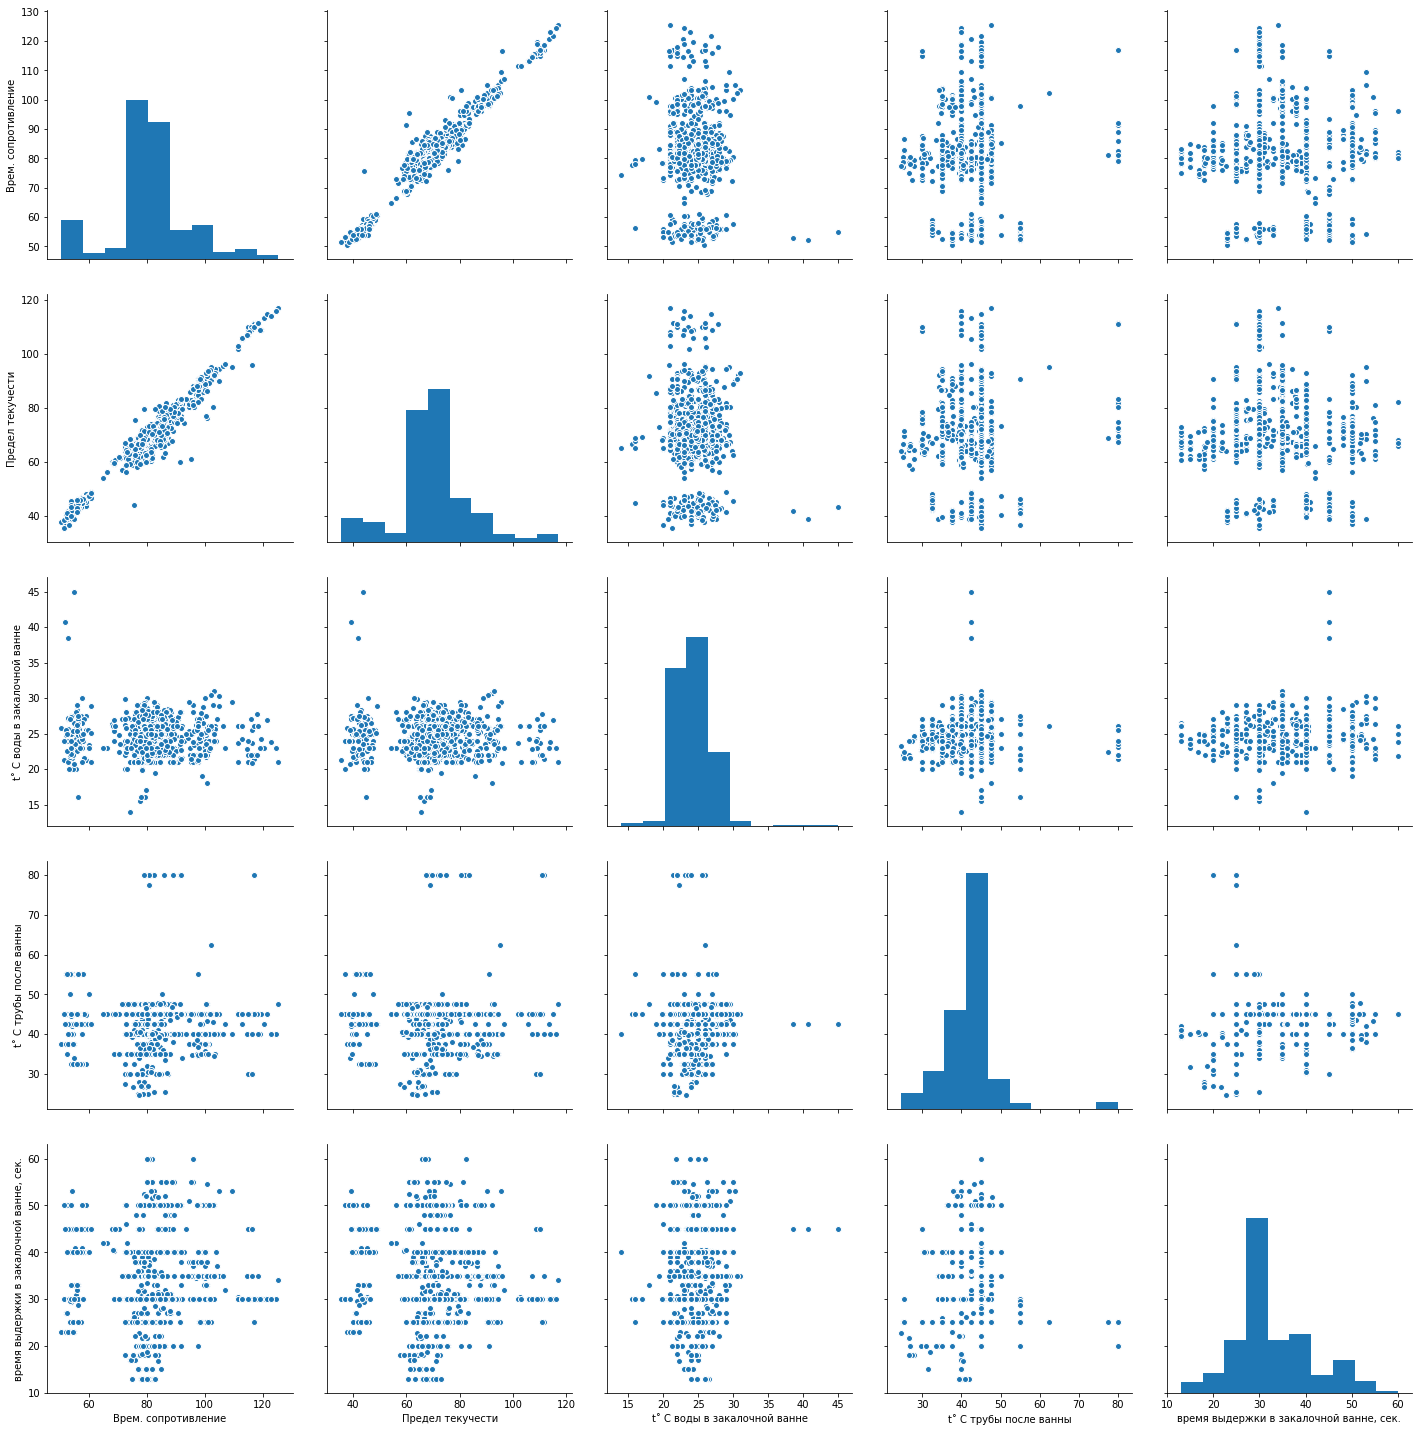

In [36]:
# plt.subplots(figsize=(20,20))
plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 10})
pair = sns.pairplot(bath_[targets+ls_bath_col], size=4)
pair.savefig('pairplot_bath.jpg', bbox_inches = 'tight')

# Обучение

In [127]:
X = bath_[ls_train_col]
y = bath_[targets]
X_valid = valid[ls_train_col]
y_valid = valid[targets]

In [128]:
def print_and_return_score(x, y, est):
    y_pred = est.predict(x)
    scr = est.score(x, y)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    corr = []
    for i in range(y.columns.size):
        corr.append(np.corrcoef(y.iloc[:, i].T, 
                                y_pred[:, i]))
        
    print('Score: ', round(scr, 2))
    print('R^2: ', round(r2, 2))
    print('MAE: ', round(mae, 2))
    print('MSE: ', round(mse, 2))
    print('Correlation Врем. сопротивление: ', round(corr[0][0][1], 2))
    print('Correlation Предел текучести: ', round(corr[1][0][1], 2))
    return [scr, mae, mse, corr[0][0][1], corr[1][0][1]]

In [129]:
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3)

rfc = RandomForestRegressor(max_features = 10, max_depth = 15, min_samples_leaf = 2, n_estimators=100, criterion='mse')
rfc.fit(X_train, y_train)

scr, mae, mse, corr1, corr2 = print_and_return_score(X_test, y_test, rfc)

Score:  0.9
R^2:  0.9
MAE:  2.68
MSE:  17.32
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94


## GridSearchCV

In [135]:
param_grid = {
    'max_depth': range(2, 18, 2),
    'max_features': range(2, 18, 2),
    'min_samples_leaf': range(1, 5),
    'n_estimators': range(50, 300, 50)
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_mean_absolute_error')

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [137]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  3.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(2, 18, 2), 'max_features': range(2, 18, 2), 'min_samples_leaf': range(1, 5), 'n_estimators': range(50, 300, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [138]:
grid_search.best_params_

{'max_depth': 16,
 'max_features': 14,
 'min_samples_leaf': 2,
 'n_estimators': 50}

In [139]:
scr, mae, mse, corr, y_pred = print_and_return_score(X_test, y_test, grid_search)

Score:  -2.32
R^2:  0.92
MAE:  2.32
MSE:  10.65
Correlation Врем. сопротивление:  0.97
Correlation Предел текучести:  0.95


In [140]:
y_predict = grid_search.predict(X_test)

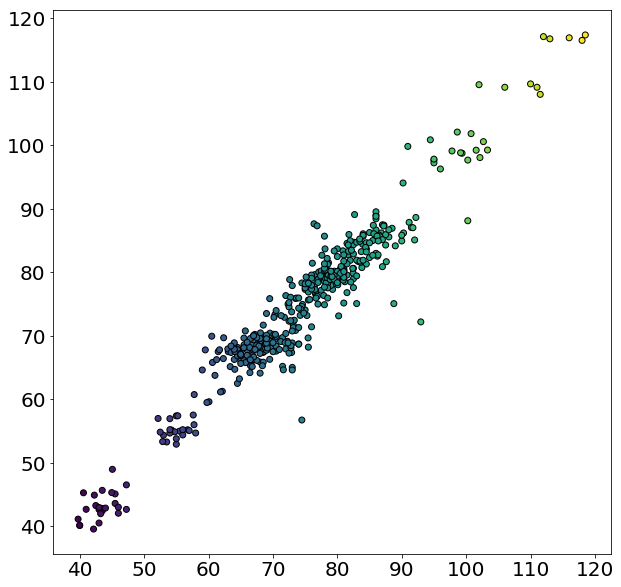

In [141]:
plt.subplots(figsize=(10,10))
plt.scatter(y_test, y_predict, marker='o', c=y_test, edgecolors='black', cmap='viridis')
# plt.colorbar()
plt.show()

## Cross-validation with KFold

In [147]:
kfold = model_selection.KFold(n_splits=5, shuffle=True)
scores = []
for train, test in kfold.split(X, y):
    x_train, y_train = X.iloc[train], y.iloc[train]
    x_test, y_test = X.iloc[test], y.iloc[test]
    grf = grid_search.best_estimator_
    grf.fit(x_train, y_train)

    scores.append(print_and_return_score(X_valid, y_valid, grf))

Score:  0.86
R^2:  0.86
MAE:  1.44
MSE:  4.05
Correlation Врем. сопротивление:  0.94
Correlation Предел текучести:  0.92
Score:  0.89
R^2:  0.89
MAE:  1.32
MSE:  3.18
Correlation Врем. сопротивление:  0.95
Correlation Предел текучести:  0.94
Score:  0.86
R^2:  0.86
MAE:  1.42
MSE:  4.07
Correlation Врем. сопротивление:  0.94
Correlation Предел текучести:  0.92
Score:  0.89
R^2:  0.89
MAE:  1.35
MSE:  3.33
Correlation Врем. сопротивление:  0.95
Correlation Предел текучести:  0.94
Score:  0.86
R^2:  0.86
MAE:  1.41
MSE:  4.23
Correlation Врем. сопротивление:  0.94
Correlation Предел текучести:  0.92


In [148]:
for i in range(5):
    tmp = []
    for j in range(5):
        tmp.append(scores[j][i])
    print(round(np.mean(tmp), 2))

0.87
1.39
3.77
0.94
0.92


In [171]:
val = grf.feature_importances_
lab = ls_train_col
dict_feat_import = dict(zip(lab, val))

<BarContainer object of 37 artists>

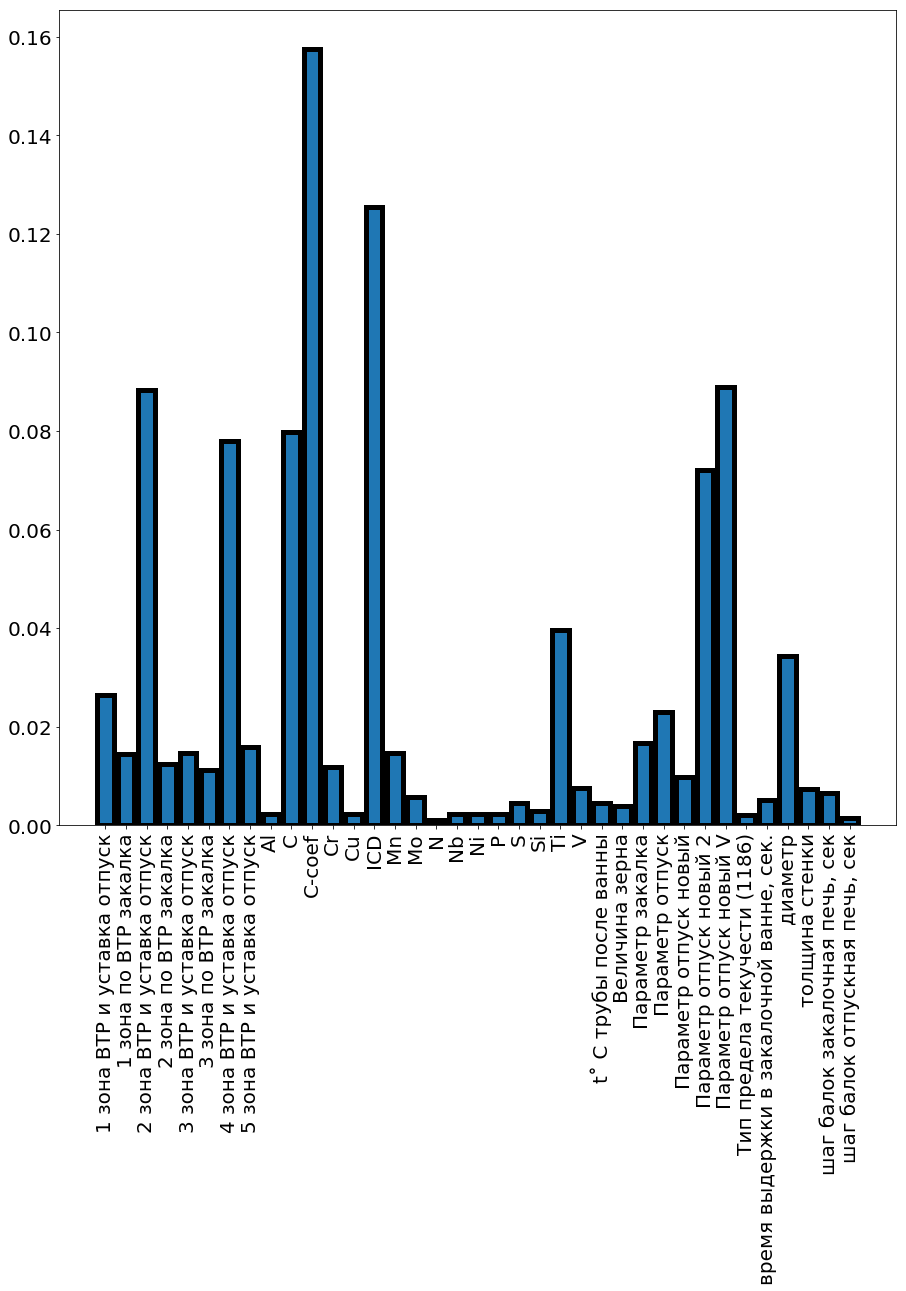

In [207]:
# plt.subplots(figsize=(20,20))
plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 20})
plt.xticks(rotation=90)
plt.bar(dict_feat_import.keys(), dict_feat_import.values(), edgecolor='black', linewidth=5)